## Import library yang dibutuhkan

In [1]:
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## Fungsi untuk load dataset dan data testing
Data yang digunakan sebagai data prediktor adalah data tahun, mileage, tax, mpg, dan engineSize sementara data respon adalah harga

In [2]:
def get_dataset():
    data = pd.read_csv('mobil/audi_edit.csv')
    data = data.drop(columns=['model', 'transmission', 'fuelType'])
    X = data[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
    X = X[:].values
    y = data['price']
    y = y[:].values
    return X, y

In [3]:
def get_datatest():
    data = pd.read_csv('mobil/audi_edit2.csv')
    data = data.drop(columns=['model', 'transmission', 'fuelType'])
    X_test = data[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
    X_test = X_test[:].values
    y_test = data['price']
    y_test = y_test[:].values
    return X_test, y_test

In [4]:
def get_datastage():
    data = pd.read_csv('mobil/audi_stage.csv')
    data = data.drop(columns=['model', 'transmission', 'fuelType'])
    X_test = data[['year', 'mileage', 'tax', 'mpg', 'engineSize']]
    X_test = X_test[:].values
    y_test = data['price']
    y_test = y_test[:].values
    return X_test, y_test

## Proses Training model
Untuk model gradien boost ada beberapa parameter yang bisa dipilih yaitu :
1. loss function : Loss function to be optimized. ‘squared_error’ refers to the squared error for regression. ‘absolute_error’ refers to the absolute error of regression and is a robust loss function.
2. jumlah estimator : The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

### Lost Function yang bisa dipakai
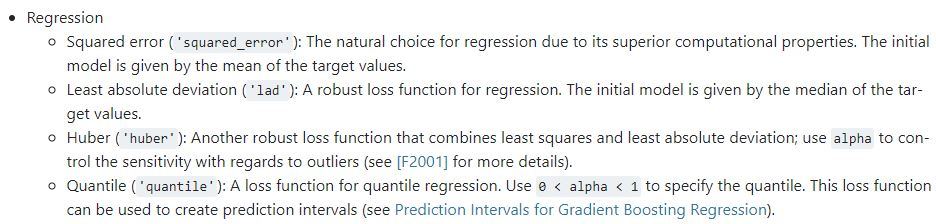

In [5]:
# define dataset
X, y = get_dataset()
X_test, y_test = get_datatest()
X_stage, y_stage = get_datastage()
panjang_stage=len(X_stage)

# Berapa banyak stage yang akan dihitung pada prediksi akhir
jumlah_stage = 3
params = {
    "n_estimators": jumlah_stage,
    "loss": "squared_error",
}

model = GradientBoostingRegressor(**params)
model.fit(X, y)

GradientBoostingRegressor(n_estimators=3)

## Plotting hasil fit model gradien boosting

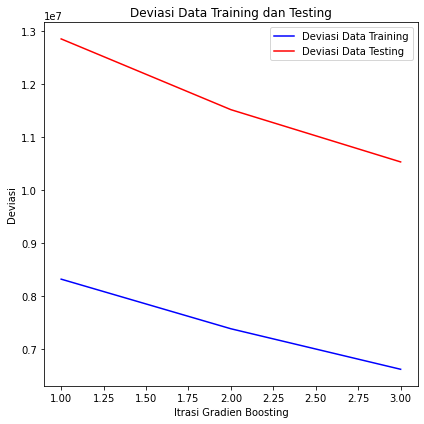

In [6]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviasi Data Training dan Testing")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    model.train_score_,
    "b-",
    label="Deviasi Data Training",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Deviasi Data Testing"
)
plt.legend(loc="upper right")
plt.xlabel("Itrasi Gradien Boosting")
plt.ylabel("Deviasi")
fig.tight_layout()
plt.show()

## Menghitung Regression Pada F0 (Menggunakan rata-rata)

In [7]:
avg_value = sum(y_stage) / len(y_stage)

diff_awal = []
stage_awal = []
score_awal = []
prediksi_awal = []
for i in range(panjang_stage):
    stage_awal.append(0)
    score_awal.append(0)
    prediksi_awal.append(avg_value)
    diff_awal.append(y_stage[i] - avg_value)

#hasil_stage = list(zip(stage_awal, score_awal, prediksi_awal, y_stage, diff_awal))
#hasil_stage = pd.DataFrame(hasil_stage, columns=['Stage','Score (Delta)','F0','y', 'y-F0'])
hasil_stage = list(zip(y_stage, prediksi_awal, diff_awal))
hasil_stage = pd.DataFrame(hasil_stage, columns=['price(y)', 'F0', 'y-F0'])
hasil_stage

,price(y),F0,y-F0
0,12750,14270.0,-1520.0
1,13000,14270.0,-1270.0
2,15900,14270.0,1630.0
3,15000,14270.0,730.0
4,14700,14270.0,430.0


## Hitung Prediksi dan Skor (F1 - F3) serta selisih prediksi (y-F)

In [8]:
all_stage = pd.DataFrame()
stage_no = 1
for pred in model.staged_predict(X_stage):
    stage_no_all = []
    stage_pred_all = []
    actual_all = []

    ttt=pred
    stage_arr=[]
    for j in range(panjang_stage):
        stage_arr.append(stage_no)
    
    pred_stage = ttt.tolist()
    actual = y_stage.tolist()
    
    stage_no_all = stage_no_all + stage_arr
    stage_pred_all = stage_pred_all + pred_stage
    actual_all = actual_all + actual
    
    diff_all = []
    for idx, val in enumerate(actual_all):
        diff = actual_all[idx] - stage_pred_all[idx]
        diff_all.append(diff)
    
    # Menghitung skor untuk setiap stage
    score_stage = []
    params = {
        "n_estimators": i,
        "loss": "squared_error"}
    model_score = GradientBoostingRegressor(**params)
    model_score.fit(X, y)
    scrr = model_score.score(X_stage, y_stage, sample_weight=None)
    
    score_sum = []
    for j in range(panjang_stage):
        score_sum.append(scrr)
    score_stage = score_stage+score_sum
    
    #addd = list(zip(stage_no_all, score_stage, stage_pred_all, actual_all, diff_all))
    #addd = pd.DataFrame(addd, columns=['Stage','Score (Delta)','F'+str(stage_no),'y', 'y-F'+str(stage_no)])
    addd = list(zip(stage_pred_all, diff_all))
    addd = pd.DataFrame(addd, columns=['F'+str(stage_no), 'y-F'+str(stage_no)])
    stage_no = stage_no+1
    hasil_stage = pd.concat([hasil_stage, addd], axis=1)
hasil_stage

,price(y),F0,y-F0,F1,y-F1,F2,y-F2,F3,y-F3
0,12750,14270.0,-1520.0,15287.000000,-2537.000000,14708.300000,-1958.300000,14187.470000,-1437.470000
1,13000,14270.0,-1270.0,15287.000000,-2287.000000,14890.550000,-1890.550000,14533.745000,-1533.745000
2,15900,14270.0,1630.0,15858.818182,41.181818,15887.951026,12.048974,15820.974106,79.025894
3,15000,14270.0,730.0,15756.375000,-756.375000,15600.112500,-600.112500,15385.363750,-385.363750
4,14700,14270.0,430.0,16310.333333,-1610.333333,16652.633333,-1952.633333,16760.188224,-2060.188224


## Proses prediksi menggunakan model hasil training

In [9]:
yhat = model.predict(X_test)
yhat

array([14187.47      , 14533.745     , 15820.97410557, 15385.36375   ,
       16760.18822432, 17156.85489099, 15385.36375   , 15820.97410557,
       14389.97      , 15385.36375   , 14389.97      , 14533.745     ,
       14533.745     , 16187.77864465, 15820.97410557, 15820.97410557,
       14736.245     , 15820.97410557, 16187.77864465, 14187.47      ,
       14533.745     , 15385.36375   , 16187.77864465, 14736.245     ,
       15820.97410557, 15820.97410557, 16760.18822432, 17156.85489099,
       16187.77864465, 16187.77864465])

In [10]:
len(yhat)

30

## Evaluasi keakuratan hasil regresi
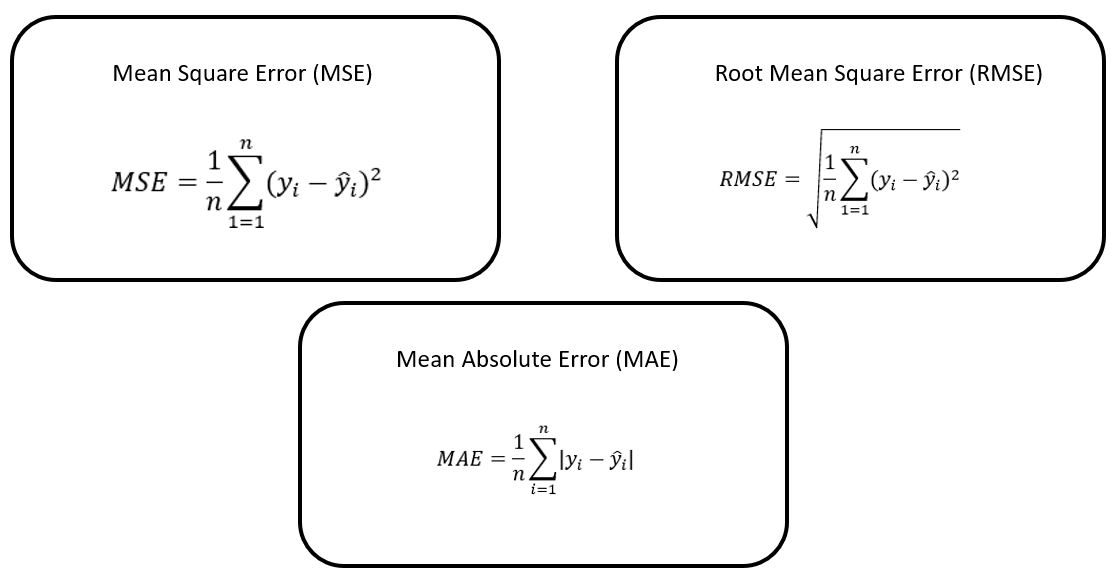

In [11]:
# Hasil MAE
mae = mean_absolute_error(y_test, yhat)
mse = mean_squared_error(y_test, yhat)
rmse = mean_squared_error(y_test, yhat, squared= False)

print("========= Hasil Evaluasi =========")
print('Hasil MAE: %.2f MAE' % (mae))
print('Hasil MSE: %.2f MSE' % (mse))
print('Hasil RMSE: %.2f RMSE' % (rmse))

========= Hasil Evaluasi =========
Hasil MAE: 2669.70 MAE
Hasil MSE: 10527067.72 MSE
Hasil RMSE: 3244.54 RMSE


## Komparasi data dan hasil prediksi regresi dalam bentuk grafik

<AxesSubplot:>

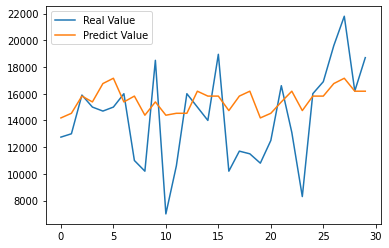

In [12]:
compare = pd.DataFrame(list(zip(y_test, yhat)), columns =['Real Value', 'Predict Value'])
compare.plot()